In [81]:
from collections import defaultdict, Counter
from itertools import product
from time import clock
import sys
import ast

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib import cm
import scipy.sparse as sps
from scipy.linalg import pinv
from scipy.spatial import distance 

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from sklearn.cluster import KMeans as kmeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import adjusted_mutual_info_score as ami, accuracy_score as accuracy, pairwise_distances

# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC

In [78]:
# Helpers

def cluster_acc(Y, clusterLabels):
    assert (Y.shape == clusterLabels.shape)
    pred = np.empty_like(Y)
    for label in set(clusterLabels):
        mask = clusterLabels == label
        sub = Y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target
#    assert max(pred) == max(Y)
#    assert min(pred) == min(Y)    
    return accuracy(Y, pred)


class myGMM(GMM):
    def transform(self, X):
        return self.predict_proba(X)
        
        
def pairwiseDistCorr(X1, X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(), d2.ravel())[0,1]

    
def aveMI(X, Y):    
    MI = MIC(X, Y) 
    return np.nanmean(MI)
    
  
def reconstructionError(projections, X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p@W)@(X.T)).T # Unproject projected data
    errors = np.square(X-reconstructed)
    return np.nanmean(errors)
    
# http://datascience.stackexchange.com/questions/6683/feature-selection-using-feature-importances-in-random-forests-with-scikit-learn          
class ImportanceSelect(BaseEstimator, TransformerMixin):
    def __init__(self, model, n=1):
         self.model = model
         self.n = n
    def fit(self, *args, **kwargs):
         self.model.fit(*args, **kwargs)
         return self
    def transform(self, X):
         return X[:,self.model.feature_importances_.argsort()[::-1][:self.n]]
                  
#http://stats.stackexchange.com/questions/90769/using-bic-to-estimate-the-number-of-k-in-kmeans    
def compute_bic(kmeans, X):
    """
    Computes the BIC metric for a given clusters
    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn
    X     :  multidimension np array of data points
    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], [centers[0][i]], 'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term

    return(BIC)

def plot_metric_vs_comp(df, problem_name, multiple_runs,
                        title, ylabel):

    plt.close()
    plt.figure()
    plt.title(title)
    plt.xlabel("N Components")
    plt.ylabel(ylabel)
    plt.grid()
    plt.tight_layout()

    ax = plt.gca()

    x_points = df.index.values
    y_points = df[1]
    if multiple_runs:
        y_points = np.mean(df.iloc[:, 1: -1], axis=1)
        y_std = np.std(df.iloc[:, 1: -1], axis=1)
        plt.plot(x_points, y_points, 'o-', linewidth=1, markersize=2,
                 label=ylabel)
        plt.fill_between(x_points, y_points - y_std,
                         y_points + y_std, alpha=0.2)
    else:
        plt.plot(x_points, y_points, 'o-', linewidth=1, markersize=2,
                 label=ylabel)

    plt.legend(loc="best")

    return plt

def run_plot_metric_vs_comp(out, dataset, metric, problem, title):
    file = out + '{}_{}.csv'.format(dataset, metric)
    df = pd.read_csv(file, header=None).dropna().set_index(0)
    multiple_runs = True if problem == 'RP' else False
    p = plot_metric_vs_comp(df=df, problem_name=problem, multiple_runs=multiple_runs,
                            title=title, ylabel=metric)

    p.savefig('{}/{}_{}.png'.format(out, dataset, metric),
                                    format='png', bbox_inches='tight', dpi=150)

def plot_complexity_curve(title, param, problem, classifier, dataset, ylim=None):
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel(param)
    plt.ylabel("Score")

    grid_search = pd.read_csv('./{}/{}_cv_results.csv'.format(problem, dataset))
    best_columns = ['mean_train_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']
    best = pd.DataFrame(grid_search[best_columns].loc[grid_search.mean_test_score.idxmax()]).T.reset_index()
    best.to_csv('./{}/{}_best.csv'.format(problem, dataset))
    best_params = ast.literal_eval(best.loc[0, 'params'])

    best_params.pop('{}__{}'.format(classifier, param))
    for _param, value in best_params.items():
        if isinstance(value, tuple):
            grid_search['param_'+_param] = grid_search['param_'+_param].apply(ast.literal_eval)
        grid_search = grid_search.loc[grid_search['param_'+_param] == value]

    df = grid_search[['param_{}__{}'.format(classifier, param), 
                      'mean_test_score', 
                      'std_test_score', 
                      'mean_train_score', 
                      'std_train_score']].sort_values(by='param_{}__{}'.format(classifier, param))
    param_values = df['param_{}__{}'.format(classifier, param)]
    train_scores_mean = df['mean_train_score']
    train_scores_std = df['std_train_score']
    test_scores_mean = df['mean_test_score']
    test_scores_std = df['std_test_score']
    plt.grid()

    plt.fill_between(param_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2)
    plt.fill_between(param_values, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2)
    plt.plot(param_values, train_scores_mean, 'o-', linewidth=1, markersize=4,
             label="Train")
    plt.plot(param_values, test_scores_mean, 'o-', linewidth=1, markersize=4,
             label="Test")

    plt.legend(loc="best")
    return plt

def make_complexity_curve(clf_name, dataset, param, problem):    
    print('Making complexity curve for', dataset)
    plt = plot_complexity_curve('Complexity Curve: {} - {} - {}'.format(clf_name, dataset, param),
                                param,
                                problem,
                                clf_name,
                                dataset,
                                ylim=None)

    plt.savefig('./{}/{}_CC_{}.png'.format(problem, dataset, param), format='png', dpi=150)
    plt.close()
    return

def plot_sse_llk(title, df, metric, dataset):
    plt.close()
    plt.figure()
    plt.title(title)
    plt.xlabel('Number of Clusters')
    plt.ylabel(metric)
    plt.grid()
    plt.tight_layout()
    
    column = 0 if dataset == 'mushroom' else 1
    plt.plot(df.index.values, df.iloc[:, column], 'o-', linewidth=1, markersize=2)
    plt.legend(loc="best")

    return plt

def read_and_plot_sse_llk(problem, output_dir, dataset, metric):
    file = output_dir + '/{}.csv'.format(metric)
    title = '{} - {}: {} vs Number of Clusters'.format(metric, dataset, problem)
    df = pd.read_csv(file).rename(columns={'Unnamed: 0':'k'}).set_index('k')
    p = plot_sse_llk(title, df, metric, dataset)
    p.savefig(
        '{}/{}_{}.png'.format(output_dir, dataset, metric),
        format='png', bbox_inches='tight', dpi=150)

def plot_acc_adjmi(title, df, metric):
    plt.close()
    plt.figure()
    plt.title(title)
    plt.xlabel('Number of Clusters')
    plt.ylabel(metric)
    plt.grid()
    plt.tight_layout()

    plt.plot(df.index.values, df['Kmeans'], 'o-', linewidth=1, markersize=2,
             label="k-Means")
    plt.plot(df.index.values, df['GMM'], 'o-', linewidth=1, markersize=2,
             label="GMM")
    plt.legend(loc="best")

    return plt

def read_and_plot_acc_adjmi(problem, output_dir, dataset, metric):
    file = output_dir + '/{}_{}.csv'.format(dataset, metric)
    title = '{} - {}: {} vs Number of Clusters'.format(dataset, problem, metric)
    df = pd.read_csv(file).T.iloc[1:].rename(columns={0:'GMM', 1:'Kmeans'})
    df.index.name = 'k'
    p = plot_acc_adjmi(title, df, metric)
    p.savefig(
        '{}/{}_{}.png'.format(output_dir, dataset, metric),
        format='png', bbox_inches='tight', dpi=150)
    
def plot_tsne(title, df):
    plt.close()
    plt.figure()
    plt.title(title)
    plt.grid()
    plt.tight_layout()

    possible_clusters = list(set(df['target']))

    ax = plt.gca()
    ax.set_title(title)
    ax.scatter(df['x'], df['y'], c=df['target'], alpha=0.7, s=5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.grid(None)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('tight')

    return plt

def read_and_plot_tsne(problem, out, dataset):
    file = out + '/{}2D.csv'.format(dataset)
    title = '{} - {}'.format(dataset, problem)
    df = pd.read_csv(file)
    p = plot_tsne(title, df)
    p.savefig(
        '{}/{}_tsne.png'.format(problem, dataset),
        format='png', bbox_inches='tight', dpi=150)

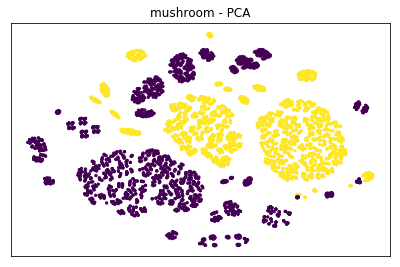

In [85]:
read_and_plot_tsne('PCA', './ICA', 'mushroom')

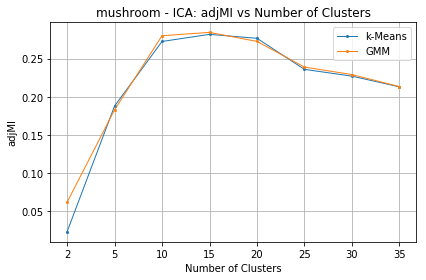

In [77]:
read_and_plot_sse_llk('PCA', './PCA', 'mushroom', 'sse')
read_and_plot_sse_llk('PCA', './PCA', 'mushroom', 'loglikelihood')
read_and_plot_sse_llk('PCA', './PCA', 'wine', 'sse')
read_and_plot_sse_llk('PCA', './PCA', 'wine', 'loglikelihood')
read_and_plot_acc_adjmi('PCA', './PCA', 'wine', 'acc')
read_and_plot_acc_adjmi('PCA', './PCA', 'wine', 'adjMI')
read_and_plot_acc_adjmi('PCA', './PCA', 'mushroom', 'acc')
read_and_plot_acc_adjmi('PCA', './PCA', 'mushroom', 'adjMI')

read_and_plot_sse_llk('ICA', './ICA', 'mushroom', 'sse')
read_and_plot_sse_llk('ICA', './ICA', 'mushroom', 'loglikelihood')
read_and_plot_sse_llk('ICA', './ICA', 'wine', 'sse')
read_and_plot_sse_llk('ICA', './ICA', 'wine', 'loglikelihood')
read_and_plot_acc_adjmi('ICA', './ICA', 'wine', 'acc')
read_and_plot_acc_adjmi('ICA', './ICA', 'wine', 'adjMI')
read_and_plot_acc_adjmi('ICA', './ICA', 'mushroom', 'acc')
read_and_plot_acc_adjmi('ICA', './ICA', 'mushroom', 'adjMI')

In [46]:
output_dir = './PCA'
dataset = 'wine'
metric = 'acc'
file = output_dir + '/{}_{}.csv'.format(dataset, metric)
df = pd.read_csv(file).T.iloc[1:].rename(columns={0:'GMM', 1:'KMeans'})
df.index.name = 'k'

In [86]:
df = pd.DataFrame([[1, 2, 3],
 [4, 5, 6],
                    [7, 8, 9],
                    [np.nan, np.nan, np.nan]],
                   columns=['A', 'B', 'C'])